<a href="https://colab.research.google.com/github/tanatiem/weather-analysis/blob/master/EDA_Bangkok_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bangkok Weather
I live in Bangkok, Thailand. The weather here is mostly hot and humid throughout the year, so Winter is really expected for many people. By the time I am writing, It is supposed to be Winter already, but it is still hot even at night. Some people say this year is not normal and hotter than last year, etc. I want to find out how it really is and, as a beginner in data analysis, I want to try exploring Weather Data from NOAA GSOD Dataset.


**Some facts about Bangkok**

- Thailand has 3 seasons: Summer (around February to May), Rainy Season (May to October), Winter (October to February)
- Bangkok does not have snow or hail, so Precipitation here is mostly about rain

In [0]:
!pip install --upgrade seaborn

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from google.cloud import bigquery
from google.colab import auth

import warnings
warnings.filterwarnings('ignore')

In [0]:
# authentication to use BigQuery
auth.authenticate_user()

In [0]:
# Parameters
project_id = 'tanat-project'

station_name = 'BANGKOK METROPOLIS'
years = range(2009, 2020)

## Dataset
- I want to explore at least 10 years of weather data. Weather data for each year are kept in separate tables named with gsod{Year} naming convention
- Using data from only 1 (out of 4) weather stations in Bangkok. The station, BANGKOK METROPOLIS, seems to be located at the central of Bangkok

In [5]:
client = bigquery.Client(project=project_id)

sql = '''
SELECT
  year, mo, da, temp, min, max, prcp
FROM
  `bigquery-public-data.noaa_gsod.gsod{}` a
INNER JOIN
  `bigquery-public-data.noaa_gsod.stations` b
ON
  a.stn = b.usaf
  AND a.wban = b.wban
WHERE
  country = 'TH'
  AND name = '{}'
'''

# Query weather data for each year
datasets = [ client.query(sql.format(i, station_name)).to_dataframe() for i in years ]

# print out each year's data shape
print('\n'.join([ '{}: {}'.format(x[0],x[1].shape) for x in zip(years, datasets)]))

2009: (365, 7)
2010: (362, 7)
2011: (365, 7)
2012: (366, 7)
2013: (365, 7)
2014: (364, 7)
2015: (362, 7)
2016: (356, 7)
2017: (363, 7)
2018: (357, 7)
2019: (113, 7)


##Data Preparation

In [6]:
# Concatenate datasets
weather = pd.concat(datasets)

# Handling missing values based on Table Schema description
weather['temp'] = weather['temp'].replace({ 9999.9 : np.nan })
weather['min'] = weather['min'].replace({ 9999.9 : np.nan })
weather['max'] = weather['max'].replace({ 9999.9 : np.nan })
weather['prcp'] = weather['prcp'].replace( { 99.99 : 0 })

weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3738 entries, 0 to 112
Data columns (total 7 columns):
year    3738 non-null object
mo      3738 non-null object
da      3738 non-null object
temp    3738 non-null float64
min     3738 non-null float64
max     3738 non-null float64
prcp    3738 non-null float64
dtypes: float64(4), object(3)
memory usage: 233.6+ KB


In [0]:
# Data processing

# Setting date index
weather['date'] = weather.apply(lambda x: 
                                datetime.datetime(int(x.year), int(x.mo), int(x.da)), 
                                axis=1)
weather = weather.set_index('date')

# Convert temperature values from farenheit to celcius
def f_to_c(temp_f):
    temp_c = (temp_f - 32) * 5/9
    return round(temp_c, 2)

for col in ['temp','min','max']:
    weather[col] = weather[col].apply(f_to_c)

# Convert precipitation from inches to milimeters
def inch_to_mm(x):
    return round(x * 25.4)

weather['prcp'] = weather['prcp'].apply(inch_to_mm)

###Missing Data
There are some dates without weather data from the source. Using reindex() to make sure that we have a row for each day in the date range, and then interpolate() all variables.

In [9]:
start_date = '{}0101'.format(years[0])
end_date = weather.index.max().strftime('%Y%m%d')

# Re-index to see if there are any days with missing data
weather = weather.reindex(pd.date_range(start_date, end_date))

# check if there is missing values occured from re-indexing
missing = weather[weather.isnull().any(axis=1)].index
# printing missing index
missing

DatetimeIndex(['2010-05-19', '2010-05-20', '2010-09-14', '2014-07-13',
               '2015-03-17', '2015-03-18', '2015-12-31', '2016-07-04',
               '2016-07-05', '2016-07-06', '2016-07-11', '2016-07-12',
               '2016-07-13', '2016-07-14', '2016-07-15', '2016-07-16',
               '2016-11-11', '2017-01-01', '2017-12-31', '2018-09-17',
               '2018-09-24', '2018-11-17', '2018-11-18', '2018-11-19',
               '2018-11-20', '2018-11-21', '2018-11-22'],
              dtype='datetime64[ns]', freq=None)

In [10]:
# Interpolate numerical variables for the missing days
weather = weather.interpolate()

# Re-setting year, month, day fields
weather['year'] = weather.index.year
weather['mo'] = weather.index.month
weather['da'] = weather.index.day

# Verify interpolated data
weather.loc[missing].head(10)

,year,mo,da,temp,min,max,prcp
2010-05-19,2010,5,19,31.313333,27.556667,36.113333,0.0
2010-05-20,2010,5,20,31.906667,27.223333,36.946667,0.0
2010-09-14,2010,9,14,28.580000,25.000000,33.000000,8.0
2014-07-13,2014,7,13,29.695000,24.250000,33.610000,4.0
2015-03-17,2015,3,17,30.016667,27.536667,34.980000,0.0
2015-03-18,2015,3,18,29.923333,27.463333,34.740000,0.0
2015-12-31,2015,12,31,28.115000,24.000000,34.000000,0.0
2016-07-04,2016,7,4,30.100000,26.722500,32.280000,2.5
2016-07-05,2016,7,5,29.920000,26.445000,32.280000,2.0
2016-07-06,2016,7,6,29.740000,26.167500,32.280000,1.5


#Exploratory Analysis

In [11]:
weather[['temp','min','max','prcp']].describe()

,temp,min,max,prcp
count,3765.000000,3765.000000,3765.000000,3765.000000
mean,29.038766,25.640212,33.859551,5.506242
std,1.735556,1.944412,2.088184,13.549292
min,18.000000,14.780000,20.390000,0.000000
25%,28.110000,24.780000,32.720000,0.000000
50%,29.170000,25.780000,34.000000,0.000000
75%,30.110000,26.890000,35.110000,4.000000
max,33.610000,30.780000,40.110000,175.000000


In [0]:
data = weather[['temp','min','max','prcp']]
data.reset_index(inplace=True)
data.columns = ['Date','Avg Temp', 'Min Temp', 'Max Temp', 'Precip']

##Lowest temperature in Bangkok
Ranking by Daily Mininum Temperature

In [13]:
rank = data.sort_values('Min Temp').head(10).reset_index(drop=True)
rank.index = rank.index + 1
rank

,Date,Avg Temp,Min Temp,Max Temp,Precip
1,2016-01-26,19.89,14.78,26.78,0.0
2,2009-01-12,22.67,15.50,28.22,0.0
3,2009-01-11,20.83,15.61,27.61,0.0
4,2016-01-25,18.00,16.11,21.39,3.0
5,2016-02-08,21.83,16.22,26.72,0.0
6,2016-01-27,22.17,16.22,27.78,0.0
7,2014-01-24,22.94,16.61,31.11,0.0
8,2014-01-25,23.94,16.78,32.28,0.0
9,2009-01-15,22.39,16.89,28.00,0.0
10,2014-01-23,21.94,17.00,28.00,0.0


##Highest temperature in Bangkok
Ranking by Daily Maximum Temperature

In [14]:
rank = data.sort_values('Max Temp', ascending=False).head(10).reset_index(drop=True)
rank.index = rank.index + 1
rank

,Date,Avg Temp,Min Temp,Max Temp,Precip
1,2013-03-26,32.11,28.22,40.11,0.0
2,2012-04-30,32.89,29.00,40.00,0.0
3,2016-04-23,32.78,29.78,39.89,0.0
4,2015-04-21,33.00,28.89,39.78,0.0
5,2010-05-10,33.61,29.61,39.72,0.0
6,2013-04-05,32.28,27.61,39.50,0.0
7,2009-04-24,32.67,27.61,39.39,0.0
8,2012-04-21,32.94,28.89,39.39,0.0
9,2013-05-15,33.33,28.89,39.39,0.0
10,2013-05-16,33.28,29.89,39.22,0.0


##Highest precipitation in Bangkok
Ranking by Daily Precipiation

In [15]:
rank = data.sort_values('Precip', ascending=False).head(10).reset_index(drop=True)
rank.index = rank.index + 1
rank

,Date,Avg Temp,Min Temp,Max Temp,Precip
1,2015-06-08,29.06,22.50,34.00,175.0
2,2009-04-27,27.00,24.50,32.61,159.0
3,2017-10-14,27.11,23.78,33.39,149.0
4,2011-06-30,28.06,24.61,33.50,128.0
5,2017-08-26,28.44,24.50,34.22,123.0
6,2017-05-16,28.11,25.28,33.39,122.0
7,2009-05-09,30.33,24.28,36.61,121.0
8,2017-10-21,27.56,25.00,34.00,110.0
9,2013-09-11,28.17,24.89,35.61,104.0
10,2013-10-16,25.33,24.72,26.39,103.0


##A quick look - time series

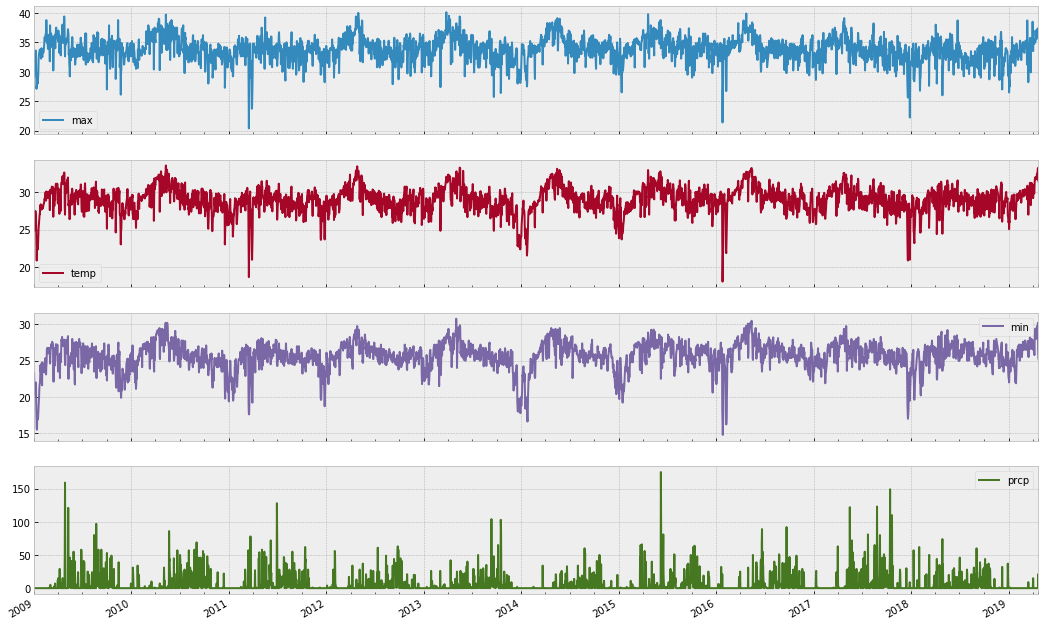

In [16]:
plt.style.use('bmh')
weather[['max','temp','min','prcp']].plot(subplots=True, figsize=(18,12));

##Distributions

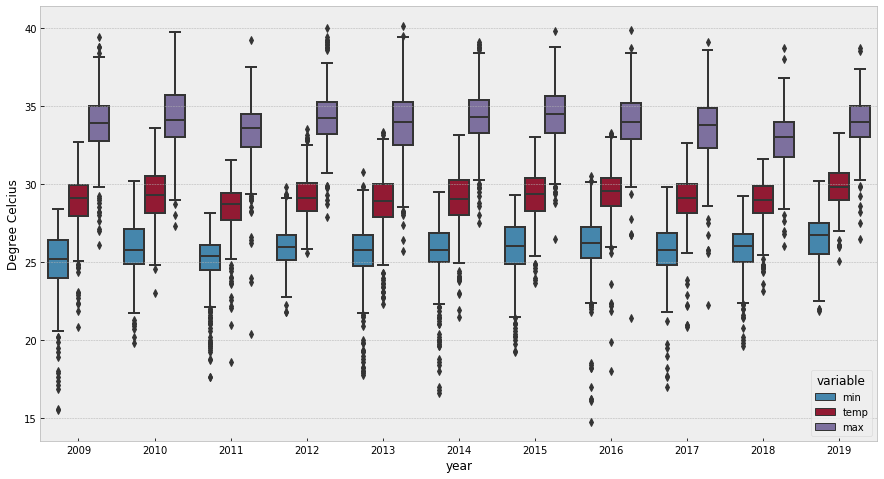

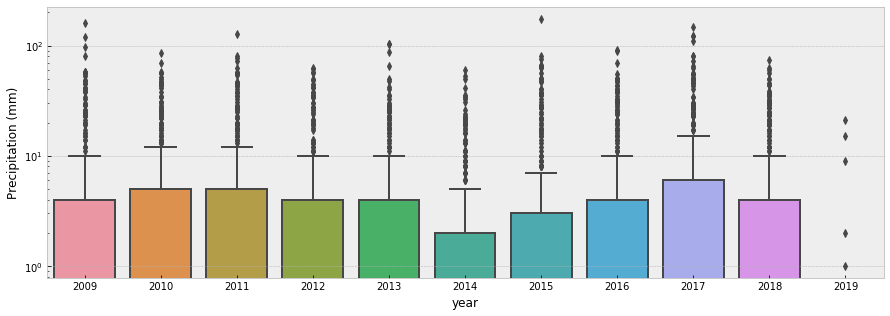

In [17]:
# melt to display
data = pd.melt(weather, 'year', ['temp','min','max'], 
               var_name='variable', value_name='degree')

plt.subplots(figsize=(15,8))

# Avg, Min, Max temp. boxplot
ax = sns.boxplot(x='year',y='degree',hue='variable', hue_order=['min','temp','max'],
           data=data)
ax.set_ylabel('Degree Celcius')
plt.show()

# Precip. boxplot
plt.subplots(figsize=(15,5))
ax  = sns.boxplot(x='year', y='prcp', data=weather)
ax.set_ylabel('Precipitation (mm)');
ax.set_yscale('log')

##Year Summary

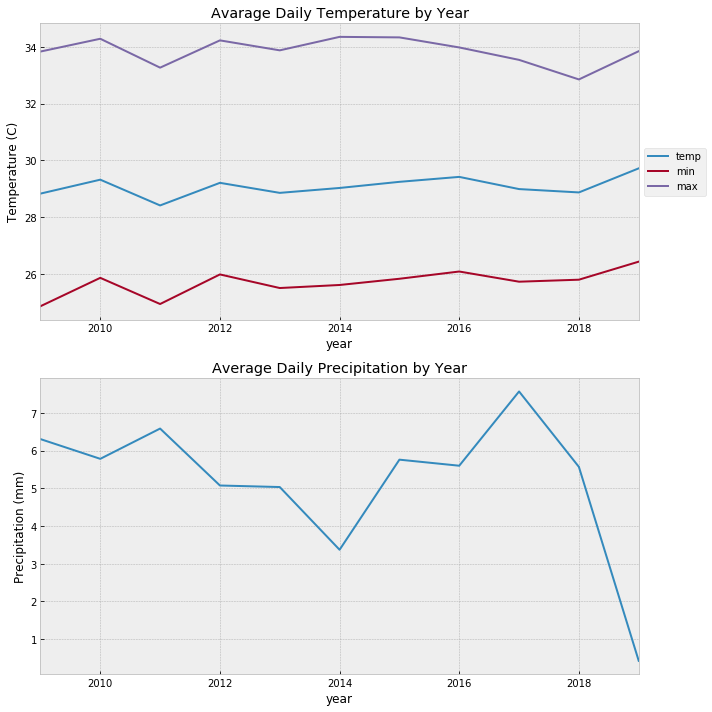

In [18]:
year_df = weather.groupby('year').mean()

f, axes = plt.subplots(nrows=2, figsize=(10,10))
ax = year_df[['temp','min','max']].plot(ax=axes[0]);
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel('Temperature (C)')
ax.set_title('Avarage Daily Temperature by Year');

ax = year_df['prcp'].plot(ax=axes[1]);
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Average Daily Precipitation by Year');

plt.tight_layout();

- 2018 is not that hot compared to the past 10 years

##Month Summary

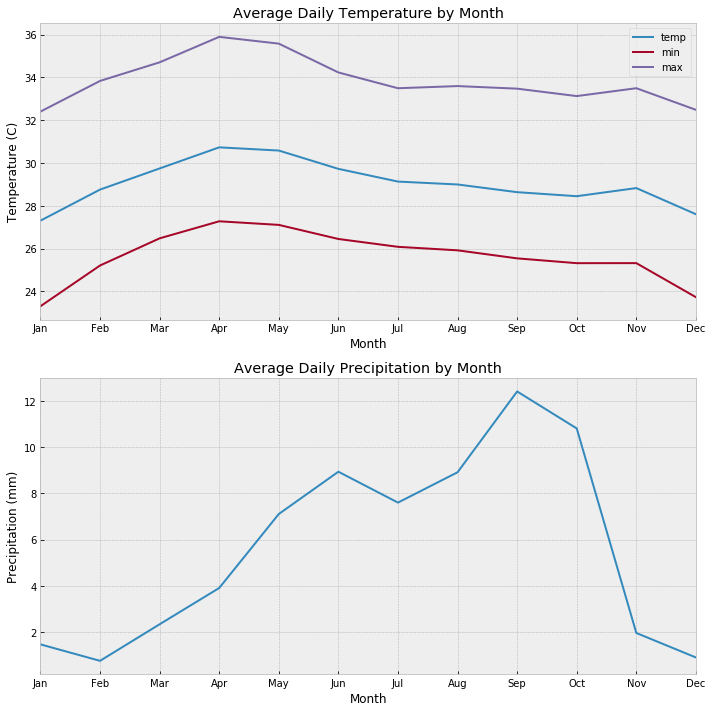

In [19]:
# for labeling
months = ['Jan','Feb','Mar','Apr','May','Jun',
          'Jul','Aug','Sep','Oct','Nov','Dec']

data = weather.groupby(['mo'], as_index=False)[['temp','min','max','prcp']].mean()

f, axes = plt.subplots(nrows=2, figsize=(10,10))
ax = data[['temp','min','max']].plot(ax=axes[0]);
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(months)
ax.set_title('Average Daily Temperature by Month');

ax = data['prcp'].plot(ax=axes[1]);
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(months)
ax.set_title('Average Daily Precipitation by Month');

plt.tight_layout();

##Heatmaps

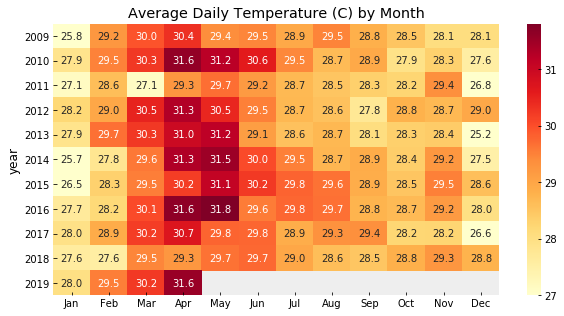

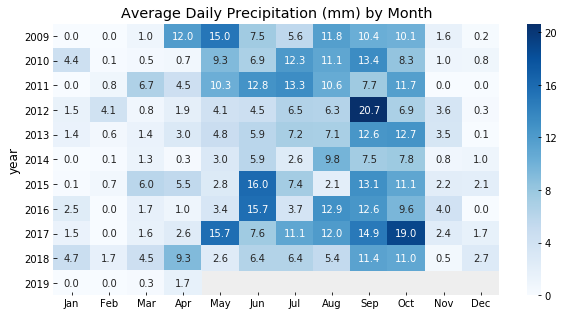

In [20]:
month_df = weather.groupby(['year','mo'], as_index=False)[['temp','prcp']].mean()

# Temperature heatmap
data = month_df.pivot('year','mo','temp')
data.columns = months

plt.subplots(figsize=(10,5))
sns.heatmap(data, cmap='YlOrRd',annot=True, fmt='.1f', vmin=27)
plt.title('Average Daily Temperature (C) by Month')
plt.yticks(rotation=0)
plt.show()

# Precipitation heatmap
data = month_df.pivot('year','mo','prcp')
data.columns = months

plt.subplots(figsize=(10,5))
sns.heatmap(data, cmap='Blues',annot=True, fmt='.1f')
plt.title('Average Daily Precipitation (mm) by Month')
plt.yticks(rotation=0);

##2018 vs 2017 Comparison

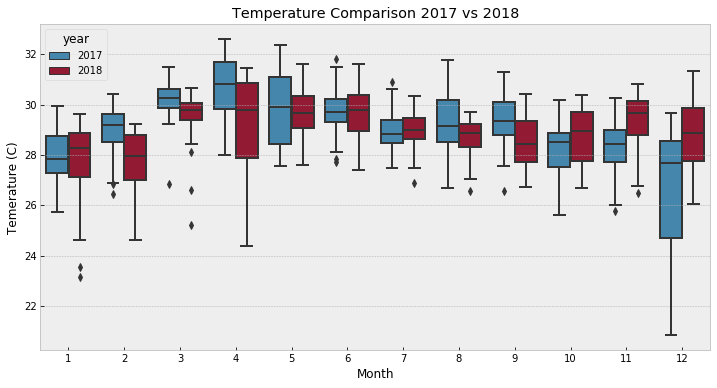

In [38]:
# slicing only for 2017, 2018 and until November as we don't have data for December
# condition = ), weather['mo'] <= 11)
data = weather[weather['year'].isin([2017,2018])]

plt.subplots(figsize=(12,6))

sns.boxplot(x='mo', y='temp', hue='year', data=data)
plt.xlabel('Month')
plt.ylabel('Temerature (C)')
plt.title('Temperature Comparison 2017 vs 2018');

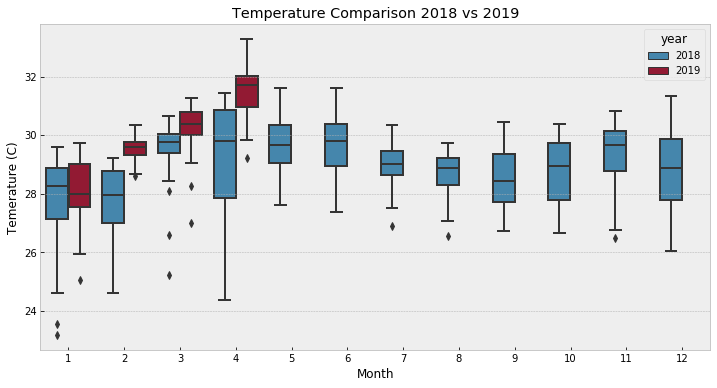

In [39]:
data = weather[weather['year'].isin([2018,2019])]

plt.subplots(figsize=(12,6))

sns.boxplot(x='mo', y='temp', hue='year', data=data)
plt.xlabel('Month')
plt.ylabel('Temerature (C)')
plt.title('Temperature Comparison 2018 vs 2019');

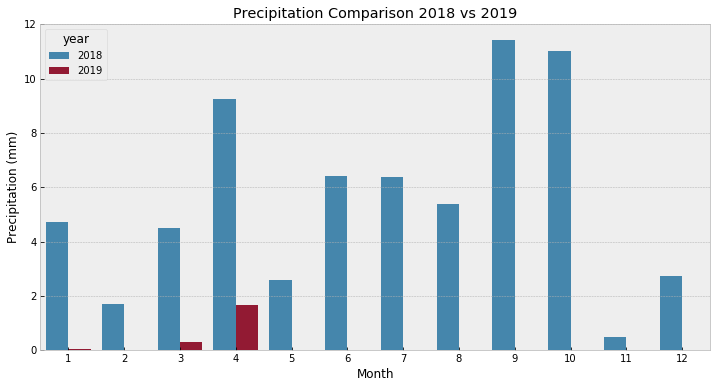

In [40]:
plt.subplots(figsize=(12,6))
sns.barplot(x='mo',y='prcp', hue='year', data=data, ci=None)
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation Comparison 2018 vs 2019');

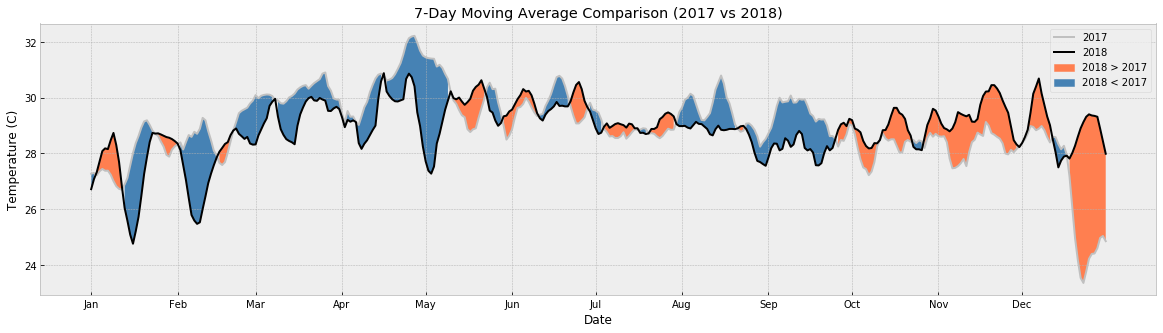

In [28]:
month_begins = ['0101','0201','0301','0401','0501','0601','0701','0801','0901','1001','1101','1201']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

data = weather[weather['year'].isin([2017,2018])]
data['monthday'] = data.index.strftime('%m%d')
data = data.pivot('monthday', 'year','temp').dropna()

window = 7
data = data.rolling(window, min_periods=1).mean()

d2017 = data.loc[:, 2017]
d2018 = data.loc[:, 2018]

f, ax = plt.subplots(figsize=(20,5))

# Plot 2017
plt.plot(data.index, d2017, label='2017', color='silver')
plt.xticks(month_begins ,months)

# Plot 2018
plt.plot(data.index, d2018, label='2018', color='k')
plt.xticks(month_begins, months)

# Where 2018 is higher than 2017 - filling a warm color
plt.fill_between(data.index, d2017, d2018, where= d2018 >= d2017,
                facecolor='coral') 

# Where 2018 is lower than 2017 -  filling a cool color
plt.fill_between(data.index, d2017, d2018, where= d2018 < d2017,
                facecolor='steelblue')

plt.title('{}-Day Moving Average Comparison (2017 vs 2018)'.format(window))
plt.ylabel('Temperature (C)')
plt.xlabel('Date')

import matplotlib.patches as mpatches
handles, labels = ax.get_legend_handles_labels()
handles = handles + [mpatches.Patch(color='coral'), mpatches.Patch(color='steelblue')]
labels = labels + ['2018 > 2017','2018 < 2017']
plt.legend(handles=handles, labels=labels);

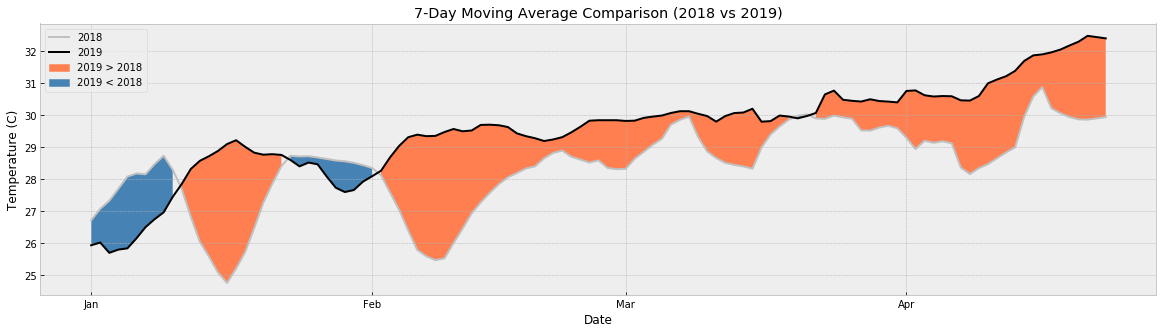

In [36]:
data = weather[weather['year'].isin([2018,2019])]
data['monthday'] = data.index.strftime('%m%d')
data = data.pivot('monthday', 'year','temp').dropna()

window = 7
data = data.rolling(window, min_periods=1).mean()

d2018 = data.loc[:, 2018]
d2019 = data.loc[:, 2019]

f, ax = plt.subplots(figsize=(20,5))

# Plot 2018
plt.plot(data.index, d2018, label='2018', color='silver')
plt.xticks(month_begins[:4] ,months)

# Plot 2019
plt.plot(data.index, d2019, label='2019', color='k')
plt.xticks(month_begins[:4], months)

# Where 2019 is higher than 2018 - filling a warm color
plt.fill_between(data.index, d2018, d2019, where= d2019 >= d2018,
                facecolor='coral') 

# Where 2019 is lower than 2018 -  filling a cool color
plt.fill_between(data.index, d2018, d2019, where= d2019 < d2018,
                facecolor='steelblue')

plt.title('{}-Day Moving Average Comparison (2018 vs 2019)'.format(window))
plt.ylabel('Temperature (C)')
plt.xlabel('Date')

import matplotlib.patches as mpatches
handles, labels = ax.get_legend_handles_labels()
handles = handles + [mpatches.Patch(color='coral'), mpatches.Patch(color='steelblue')]
labels = labels + ['2019 > 2018','2019 < 2018']
plt.legend(handles=handles, labels=labels);